In [1]:
%pip install numpy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Standard Deviation (Verilog vs Python Model): 0.00061372
Standard Deviation (Verilog vs True Sigmoid): 0.00647987


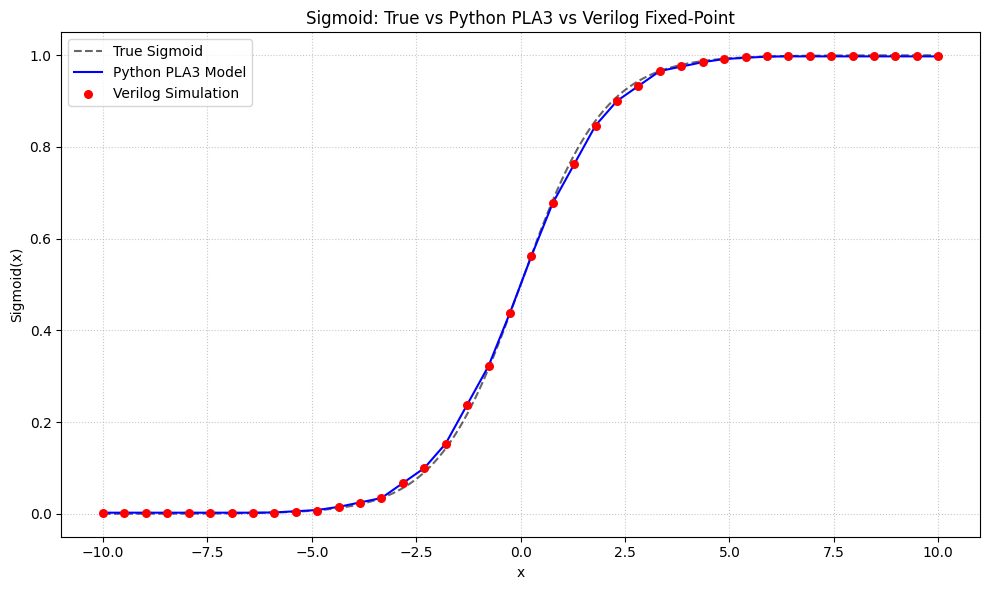

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class PiecewiseSigmoid:
    def __init__(self, num_slices=10, input_range=(-6, 6)):
        self.num_slices = num_slices
        self.input_range = input_range
        self.breakpoints = np.linspace(input_range[0], input_range[1], num_slices + 1)
        self.slopes, self.intercepts = self._compute_segments()

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _compute_segments(self):
        slopes = []
        intercepts = []
        for i in range(len(self.breakpoints) - 1):
            x1, x2 = self.breakpoints[i], self.breakpoints[i + 1]
            y1, y2 = self._sigmoid(x1), self._sigmoid(x2)
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            slopes.append(slope)
            intercepts.append(intercept)
        return slopes, intercepts

    def __call__(self, x):
        if isinstance(x, (int, float)):
            return self._evaluate(x)
        elif isinstance(x, np.ndarray):
            return np.array([self._evaluate(val) for val in x])
        else:
            raise ValueError("Input must be a scalar or a numpy array.")

    def _evaluate(self, x):
        if x <= self.breakpoints[0]:
            return self._sigmoid(self.breakpoints[0])
        elif x >= self.breakpoints[-1]:
            return self._sigmoid(self.breakpoints[-1])
        for i in range(len(self.breakpoints) - 1):
            if self.breakpoints[i] <= x < self.breakpoints[i + 1]:
                return self.slopes[i] * x + self.intercepts[i]
        return self._sigmoid(x)

# 1. Generate Data
# X values corresponding to the Verilog simulation (40 points from -10 to 10)
x_values_sim = np.linspace(-10, 10, 40)

# True Sigmoid
y_true = 1 / (1 + np.exp(-x_values_sim))

# Python PLA3 Model
sigmoid_approx3 = PiecewiseSigmoid(num_slices=9, input_range=(-6, 6))
y_pla3_python = sigmoid_approx3(x_values_sim)

# Verilog Simulation Results (Extracted from your table)
y_verilog = np.array([
    0.00244141, 0.00244141, 0.00244141, 0.00244141, 0.00244141,
    0.00244141, 0.00244141, 0.00244141, 0.00146484, 0.00390625,
    0.00683594, 0.01416016, 0.02392578, 0.03466797, 0.06738281,
    0.10009766, 0.15283203, 0.23730469, 0.32226562, 0.43798828,
    0.56152344, 0.67724609, 0.76220703, 0.84667969, 0.89941406,
    0.93212891, 0.96484375, 0.97558594, 0.98535156, 0.99267578,
    0.99560547, 0.99804688, 0.99755859, 0.99755859, 0.99755859,
    0.99755859, 0.99755859, 0.99755859, 0.99755859, 0.99755859
])

# 2. Calculate Standard Deviation of Error
# Error vs Python Model (Quantization Noise)
error_vs_python = y_verilog - y_pla3_python
std_dev_quantization = np.std(error_vs_python)

# Error vs True Sigmoid (Total Approximation Error)
error_vs_true = y_verilog - y_true
std_dev_total = np.std(error_vs_true)

print(f"Standard Deviation (Verilog vs Python Model): {std_dev_quantization:.8f}")
print(f"Standard Deviation (Verilog vs True Sigmoid): {std_dev_total:.8f}")

# 3. Plotting
plt.figure(figsize=(10, 6))

# High resolution x for smooth True Sigmoid curve
x_smooth = np.linspace(-10, 10, 200)
plt.plot(x_smooth, 1 / (1 + np.exp(-x_smooth)), label="True Sigmoid", color='black', linestyle="--", alpha=0.6)

# Python PLA3 (Line)
plt.plot(x_values_sim, y_pla3_python, label="Python PLA3 Model", color="blue", linewidth=1.5)

# Verilog Simulation (Dots)
plt.scatter(x_values_sim, y_verilog, label="Verilog Simulation", color="red", s=30, zorder=5)

plt.legend()
plt.xlabel("x")
plt.ylabel("Sigmoid(x)")
plt.title("Sigmoid: True vs Python PLA3 vs Verilog Fixed-Point")
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

Standard Deviation (Verilog vs Python Model): 0.00027720
Standard Deviation (Verilog vs True Tanh): 0.01406153


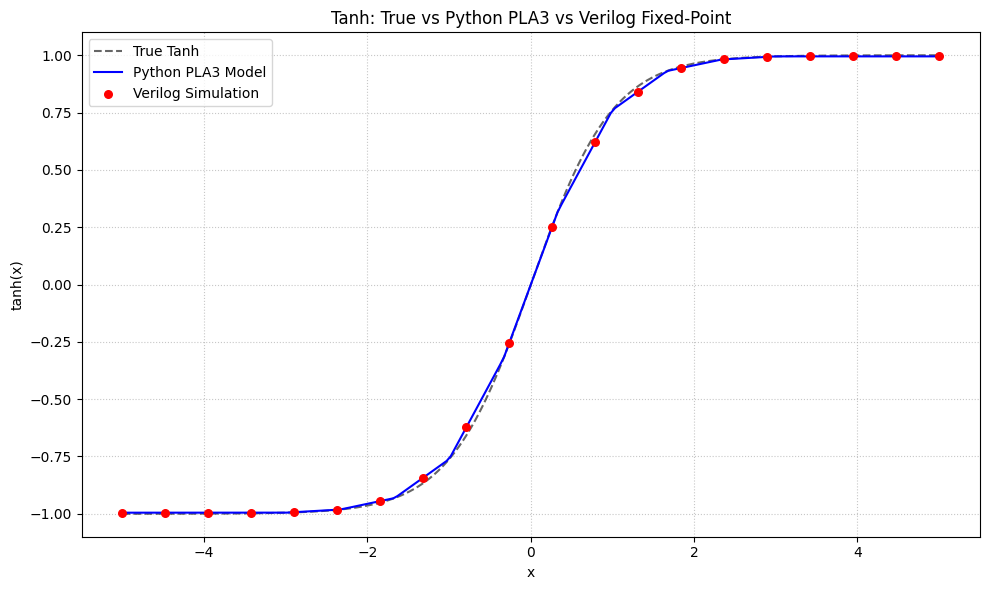

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class PiecewiseTanh:
    def __init__(self, num_slices=9, input_range=(-3, 3)):
        """
        Piecewise-linear approximation of tanh(x).
        :param num_slices: number of linear segments.
        :param input_range: input range where approximation is built.
        """
        self.num_slices = num_slices
        self.input_range = input_range
        self.breakpoints = np.linspace(input_range[0], input_range[1], num_slices + 1)
        self.slopes, self.intercepts = self._compute_segments()

    def _tanh(self, x):
        """True tanh function."""
        return np.tanh(x)

    def _compute_segments(self):
        """Compute slope and intercept for each linear slice."""
        slopes = []
        intercepts = []
        for i in range(len(self.breakpoints) - 1):
            x1, x2 = self.breakpoints[i], self.breakpoints[i + 1]
            y1, y2 = self._tanh(x1), self._tanh(x2)
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            slopes.append(slope)
            intercepts.append(intercept)
        return slopes, intercepts

    def __call__(self, x):
        """Evaluate tanh approximation for scalar or np.ndarray."""
        if isinstance(x, (int, float)):
            return self._evaluate(x)
        elif isinstance(x, np.ndarray):
            return np.array([self._evaluate(val) for val in x])
        else:
            raise ValueError("Input must be scalar or numpy array.")

    def _evaluate(self, x):
        """Evaluate approximation for one input value."""
        # Outside the approximation range: clamp
        if x <= self.breakpoints[0]:
            return self._tanh(self.breakpoints[0])
        if x >= self.breakpoints[-1]:
            return self._tanh(self.breakpoints[-1])

        # Find interval
        for i in range(len(self.breakpoints) - 1):
            if self.breakpoints[i] <= x < self.breakpoints[i + 1]:
                return self.slopes[i] * x + self.intercepts[i]

        # Should never reach here
        return self._tanh(x)

# 1. Generate Data
# X values corresponding to the Verilog simulation (20 points from -5 to 5)
x_values_sim = np.linspace(-5, 5, 20)

# True Tanh
y_true = np.tanh(x_values_sim)

# Python PLA3 Model
tanh_approx3 = PiecewiseTanh(num_slices=9, input_range=(-3, 3))
y_pla3_python = tanh_approx3(x_values_sim)

# Verilog Simulation Results (Extracted from your table)
y_verilog = np.array([
    -0.99511719, -0.99511719, -0.99511719, -0.99511719,
    -0.99316406, -0.98242188, -0.94433594, -0.84228516,
    -0.62255859, -0.25341797,  0.25292969,  0.62207031,
     0.84179688,  0.94384766,  0.98193359,  0.99267578,
     0.99511719,  0.99511719,  0.99511719,  0.99511719
], dtype=np.float64)

# 2. Calculate Standard Deviation of Error
# Error vs Python Model (Quantization Noise)
error_vs_python = y_verilog - y_pla3_python
std_dev_quantization = np.std(error_vs_python)

# Error vs True Tanh (Total Approximation Error)
error_vs_true = y_verilog - y_true
std_dev_total = np.std(error_vs_true)

print(f"Standard Deviation (Verilog vs Python Model): {std_dev_quantization:.8f}")
print(f"Standard Deviation (Verilog vs True Tanh): {std_dev_total:.8f}")

# 3. Plotting
plt.figure(figsize=(10, 6))

# High resolution x for smooth True Tanh curve and PLA model line
x_smooth = np.linspace(-5, 5, 200)
y_true_smooth = np.tanh(x_smooth)
y_pla3_smooth = tanh_approx3(x_smooth)

# True Tanh (Dashed Black Line)
plt.plot(x_smooth, y_true_smooth, label="True Tanh", color='black', linestyle="--", alpha=0.6)

# Python PLA3 (Blue Line) - Shows the segments
plt.plot(x_smooth, y_pla3_smooth, label="Python PLA3 Model", color="blue", linewidth=1.5)

# Verilog Simulation (Red Dots)
plt.scatter(x_values_sim, y_verilog, label="Verilog Simulation", color="red", s=30, zorder=5)

plt.legend()
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.title("Tanh: True vs Python PLA3 vs Verilog Fixed-Point")
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [3]:
# ============================================================
# VERILOG COEFFICIENT GENERATOR
# ============================================================

import numpy as np

def generate_verilog_constants(fn, fn_name, num_slices, input_range, frac_bits=11):
    """
    Generate Verilog localparam constants for piecewise-linear approximation.
    
    Args:
        fn: function to approximate (e.g., sigmoid or tanh)
        fn_name: string name for comments
        num_slices: number of linear segments
        input_range: tuple (min, max) for approximation range
        frac_bits: fractional bits in Q format (default Q5.11 uses 11)
    """
    scale = 1 << frac_bits  # 2^11 = 2048 for Q5.11
    
    # Compute breakpoints
    breakpoints = np.linspace(input_range[0], input_range[1], num_slices + 1)
    
    # Compute slopes and intercepts
    slopes = []
    intercepts = []
    for i in range(len(breakpoints) - 1):
        x1, x2 = breakpoints[i], breakpoints[i + 1]
        y1, y2 = fn(x1), fn(x2)
        m = (y2 - y1) / (x2 - x1)
        c = y1 - m * x1
        slopes.append(m)
        intercepts.append(c)
    
    # Print Verilog constants
    print(f"// ============================================================")
    print(f"// {fn_name.upper()} {num_slices}-SLICE CONSTANTS (Q5.{frac_bits} FORMAT)")
    print(f"// Input range: [{input_range[0]}, {input_range[1]}]")
    print(f"// Scale factor: 1.0 = {scale}")
    print(f"// ============================================================\n")
    
    # Breakpoints
    print("// Breakpoints")
    for i, bp in enumerate(breakpoints):
        bp_q = int(round(bp * scale))
        sign = "-" if bp_q < 0 else ""
        print(f"localparam signed [15:0] BP_{i} = {sign}16'sd{abs(bp_q)}; // {bp:.4f}")
    print()
    
    # Slopes
    print("// Slopes (m)")
    for i, m in enumerate(slopes):
        m_q = int(round(m * scale))
        sign = "-" if m_q < 0 else ""
        print(f"localparam signed [15:0] M_{i} = {sign}16'sd{abs(m_q)}; // {m:.6f}")
    print()
    
    # Intercepts
    print("// Intercepts (c)")
    for i, c in enumerate(intercepts):
        c_q = int(round(c * scale))
        sign = "-" if c_q < 0 else ""
        print(f"localparam signed [15:0] C_{i} = {sign}16'sd{abs(c_q)}; // {c:.6f}")
    print()
    
    # Saturation values
    y_low = fn(input_range[0])
    y_high = fn(input_range[1])
    print("// Saturation Values")
    print(f"localparam signed [15:0] SAT_LOW  = 16'sd{int(round(y_low * scale))}; // {y_low:.6f}")
    print(f"localparam signed [15:0] SAT_HIGH = 16'sd{int(round(y_high * scale))}; // {y_high:.6f}")
    print("\n")

# ============================================================
# SIGMOID FUNCTION
# ============================================================
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ============================================================
# GENERATE CONSTANTS FOR BOTH FUNCTIONS
# ============================================================

print("=" * 70)
print("SIGMOID 9-SLICE VERILOG CONSTANTS")
print("=" * 70)
generate_verilog_constants(sigmoid, "sigmoid", 9, (-6, 6))

print("=" * 70)
print("TANH 9-SLICE VERILOG CONSTANTS")
print("=" * 70)
generate_verilog_constants(np.tanh, "tanh", 9, (-3, 3))

SIGMOID 9-SLICE VERILOG CONSTANTS
// ============================================================
// SIGMOID 9-SLICE CONSTANTS (Q5.11 FORMAT)
// Input range: [-6, 6]
// Scale factor: 1.0 = 2048
// ============================================================

// Breakpoints
localparam signed [15:0] BP_0 = -16'sd12288; // -6.0000
localparam signed [15:0] BP_1 = -16'sd9557; // -4.6667
localparam signed [15:0] BP_2 = -16'sd6827; // -3.3333
localparam signed [15:0] BP_3 = -16'sd4096; // -2.0000
localparam signed [15:0] BP_4 = -16'sd1365; // -0.6667
localparam signed [15:0] BP_5 = 16'sd1365; // 0.6667
localparam signed [15:0] BP_6 = 16'sd4096; // 2.0000
localparam signed [15:0] BP_7 = 16'sd6827; // 3.3333
localparam signed [15:0] BP_8 = 16'sd9557; // 4.6667
localparam signed [15:0] BP_9 = 16'sd12288; // 6.0000

// Slopes (m)
localparam signed [15:0] M_0 = 16'sd11; // 0.005133
localparam signed [15:0] M_1 = 16'sd39; // 0.018847
localparam signed [15:0] M_2 = 16'sd130; // 0.063568
localparam s

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

generate_verilog_constants(sigmoid, "sigmoid", 9, (-6, 6))

// ============================================================
// SIGMOID 9-SLICE CONSTANTS (Q5.11 FORMAT)
// Input range: [-6, 6]
// Scale factor: 1.0 = 2048
// ============================================================

// Breakpoints
localparam signed [15:0] BP_0 = -16'sd12288; // -6.0000
localparam signed [15:0] BP_1 = -16'sd9557; // -4.6667
localparam signed [15:0] BP_2 = -16'sd6827; // -3.3333
localparam signed [15:0] BP_3 = -16'sd4096; // -2.0000
localparam signed [15:0] BP_4 = -16'sd1365; // -0.6667
localparam signed [15:0] BP_5 = 16'sd1365; // 0.6667
localparam signed [15:0] BP_6 = 16'sd4096; // 2.0000
localparam signed [15:0] BP_7 = 16'sd6827; // 3.3333
localparam signed [15:0] BP_8 = 16'sd9557; // 4.6667
localparam signed [15:0] BP_9 = 16'sd12288; // 6.0000

// Slopes (m)
localparam signed [15:0] M_0 = 16'sd11; // 0.005133
localparam signed [15:0] M_1 = 16'sd39; // 0.018847
localparam signed [15:0] M_2 = 16'sd130; // 0.063568
localparam signed [15:0] M_3 = 16'sd338; // 0.